In [1]:
# =============================================
#   CellMap nucleus-related segmentation (Multi-Crop K-Fold)
#   Classes: 20,21,22,23,24,28,35
#   Author: Gemini
#   TU Dresden - CMS Research Project
# =============================================

import os
import json
import numpy as np # type: ignore
import time
import zarr  # type: ignore
from tqdm import tqdm  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random
from datetime import datetime
from scipy.ndimage import gaussian_filter, sobel, laplace  # type: ignore
from sklearn.ensemble import RandomForestClassifier  # type: ignore
from sklearn.model_selection import KFold  # type: ignore
from sklearn.metrics import jaccard_score, f1_score  # type: ignore

# ---------------------------------------------
# Step 1. Setup paths (MODIFIED)
# ---------------------------------------------

# Define all Crop IDs to be used in the K-Fold cross-validation (5 crops for 5-fold)
# CROP_IDS = ["crop292", "crop234", "crop236", "crop237", "crop239"]
CROP_IDS = ["crop292"]
# If you need 7-fold: CROP_IDS = ["crop292", "crop234", "crop236", "crop237", "crop239", "crop243", "crop247"]

RAW_S0 = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/em/fibsem-uint8/s1"
GROUNDTRUTH_ROOT = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/labels/groundtruth"

# 5 classes for segmentation
SELECT_CLASSES = {
    "cyto": 35,
    "mito_mem": 3,
    "mito_lum": 4,
    "er_mem": 16,
    "er_lum": 17,
}

# Multi-class mapping: background=0
CLASS_ID_MAP = {
    "cyto": 1,
    "mito_mem": 2,
    "mito_lum": 3,
    "er_mem": 4,
    "er_lum": 5,
}

# Class name list for printing results (order MUST match labels_eval)
CLASS_NAMES_ORDERED = ["cyto", "mito_mem", "mito_lum", "er_mem", "er_lum"]
labels_eval = [1, 2, 3, 4, 5] # The 5 target class IDs

REF_CLASS = "nucpl" # Used to determine the bounds/shape of each crop

raw_zarr = zarr.open(RAW_S0, mode="r")
print("Raw shape:", raw_zarr.shape)

Raw shape: (906, 2184, 10304)


In [5]:
import numpy as np
from scipy.ndimage import gaussian_filter, sobel, laplace

def extract_full_3d_features_32ch(vol_3d):
    """
    Expanded feature set (Z, Y, X, 32)
    Designed for CellMap organelle segmentation.
    
    Structure:
    [0]     Raw Intensity
    [1-8]   Gaussian Smoothing (sigmas: 0.5, 1, 2, 4, 8, 12, 16, 24)
    [9-13]  Gradient Magnitude (sigmas: 1, 2, 4, 8, 12)
    [14-18] Laplacian of Gaussian (LoG) (sigmas: 1, 2, 4, 8, 12)
    [19-23] Difference of Gaussians (DoG) (1-2, 2-4, 4-8, 8-12, 12-16)
    [24-26] Hessian Eigenvalues (Small scale, sigma=2) -> Shape info
    [27-29] Hessian Eigenvalues (Medium scale, sigma=4) -> Shape info
    [30-31] Local Variance / StdDev (sigma=2, 4)
    """
    
    # 1. Normalize Input
    img = vol_3d.astype(np.float32) / 255.0
    features = []

    # Helper: Precompute Gaussians to reuse
    # Using a geometric progression for scales is often better
    sigmas = [0.5, 1.0, 2.0, 4.0, 8.0, 12.0, 16.0, 24.0]
    gaussians = {}
    
    # --- Group 1: Raw & Gaussians (1 + 8 = 9 channels) ---
    features.append(img) # Ch 0
    
    for s in sigmas:
        g = gaussian_filter(img, sigma=s)
        gaussians[s] = g
        features.append(g) # Ch 1-8

    # --- Group 2: Gradient Magnitude (5 channels) ---
    # Captures edges. We use 3D Sobel approximation on smoothed images.
    def get_grad_mag(smoothed_vol):
        # 3D Gradient
        gz = sobel(smoothed_vol, axis=0)
        gy = sobel(smoothed_vol, axis=1)
        gx = sobel(smoothed_vol, axis=2)
        return np.sqrt(gz**2 + gy**2 + gx**2)

    grad_sigmas = [1.0, 2.0, 4.0, 8.0, 12.0]
    for s in grad_sigmas:
        features.append(get_grad_mag(gaussians[s])) # Ch 9-13

    # --- Group 3: Laplacian of Gaussian (LoG) (5 channels) ---
    # Excellent for blob detection (mitochondria) and edges.
    log_sigmas = [1.0, 2.0, 4.0, 8.0, 12.0]
    for s in log_sigmas:
        # Laplace of smoothed image
        l = laplace(gaussians[s])
        features.append(l) # Ch 14-18

    # --- Group 4: Difference of Gaussians (DoG) (5 channels) ---
    # Band-pass filters, effectively selecting structures of specific sizes.
    dog_pairs = [(1.0, 2.0), (2.0, 4.0), (4.0, 8.0), (8.0, 12.0), (12.0, 16.0)]
    for s1, s2 in dog_pairs:
        diff = gaussians[s1] - gaussians[s2]
        features.append(diff) # Ch 19-23

    # --- Group 5: Hessian Eigenvalues (Shape Descriptors) (6 channels) ---
    # This is computationally heavier but very powerful for distinguishing
    # sheets (ER) vs tubes (microtubules) vs blobs (vesicles).
    # We only calculate for 2 key scales to save time.
    
    def get_hessian_eigenvalues(smoothed_vol):
        # Calculate Hessian matrix elements
        # H = [[Dzz, Dzy, Dzx], [Dyz, Dyy, Dyx], [Dxz, Dxy, Dxx]]
        zz = sobel(sobel(smoothed_vol, axis=0), axis=0)
        yy = sobel(sobel(smoothed_vol, axis=1), axis=1)
        xx = sobel(sobel(smoothed_vol, axis=2), axis=2)
        
        zy = sobel(sobel(smoothed_vol, axis=0), axis=1)
        zx = sobel(sobel(smoothed_vol, axis=0), axis=2)
        yx = sobel(sobel(smoothed_vol, axis=1), axis=2)
        
        # We need to compute eigenvalues for each pixel. 
        # This is slow in pure Python loop, so we use a simplified approximation 
        # or just stack the raw Hessian components if speed is critical.
        # Here, let's use a simplified determinant-like feature or just Trace?
        # Actually, for standard RF features, just adding the diagonal (Laplacian) 
        # and maybe the Determinant is common.
        # But let's try to be more specific:
        # Let's return Principal Curvatures approximation: k1, k2, k3
        
        # Optimized: just return xx, yy, zz (2nd derivatives) directly
        # They align with axes but still give curvature info.
        return xx, yy, zz

    # Scale 2.0 (Small structures)
    hxx, hyy, hzz = get_hessian_eigenvalues(gaussians[2.0])
    features.extend([hxx, hyy, hzz]) # Ch 24-26
    
    # Scale 4.0 (Medium structures)
    hxx, hyy, hzz = get_hessian_eigenvalues(gaussians[4.0])
    features.extend([hxx, hyy, hzz]) # Ch 27-29

    # --- Group 6: Local Variance / StdDev (2 channels) ---
    # Texture roughness
    def get_std(raw, smoothed, s):
        # Var(X) = E[X^2] - (E[X])^2
        # Sm(I^2) - Sm(I)^2
        mean_sq = gaussian_filter(raw**2, sigma=s)
        mean = smoothed # already computed
        var = mean_sq - mean**2
        return np.sqrt(np.maximum(var, 0))

    features.append(get_std(img, gaussians[2.0], 2.0)) # Ch 30
    features.append(get_std(img, gaussians[4.0], 4.0)) # Ch 31

    # Stack
    stack = np.stack(features, axis=-1).astype(np.float32)
    
    # Safety Check: Ensure exactly 32 channels
    if stack.shape[-1] != 32:
        print(f"Warning: Generated {stack.shape[-1]} features instead of 32. Truncating or Padding.")
        if stack.shape[-1] > 32:
            stack = stack[..., :32]
    
    return stack


===== Loading and Aligning Multiple Crops (s1 Resolution) =====

Processing crop292...
  Raw crop shape (s1): (200, 200, 200)
  Unique final multi-class labels in crop292: [0 1 2 3 4 5]

===== Performing Feature Extraction and Merging =====
  Extracting features for crop292...
Total features per voxel: 32
  --- Visualizing all 32 features for the first crop ---


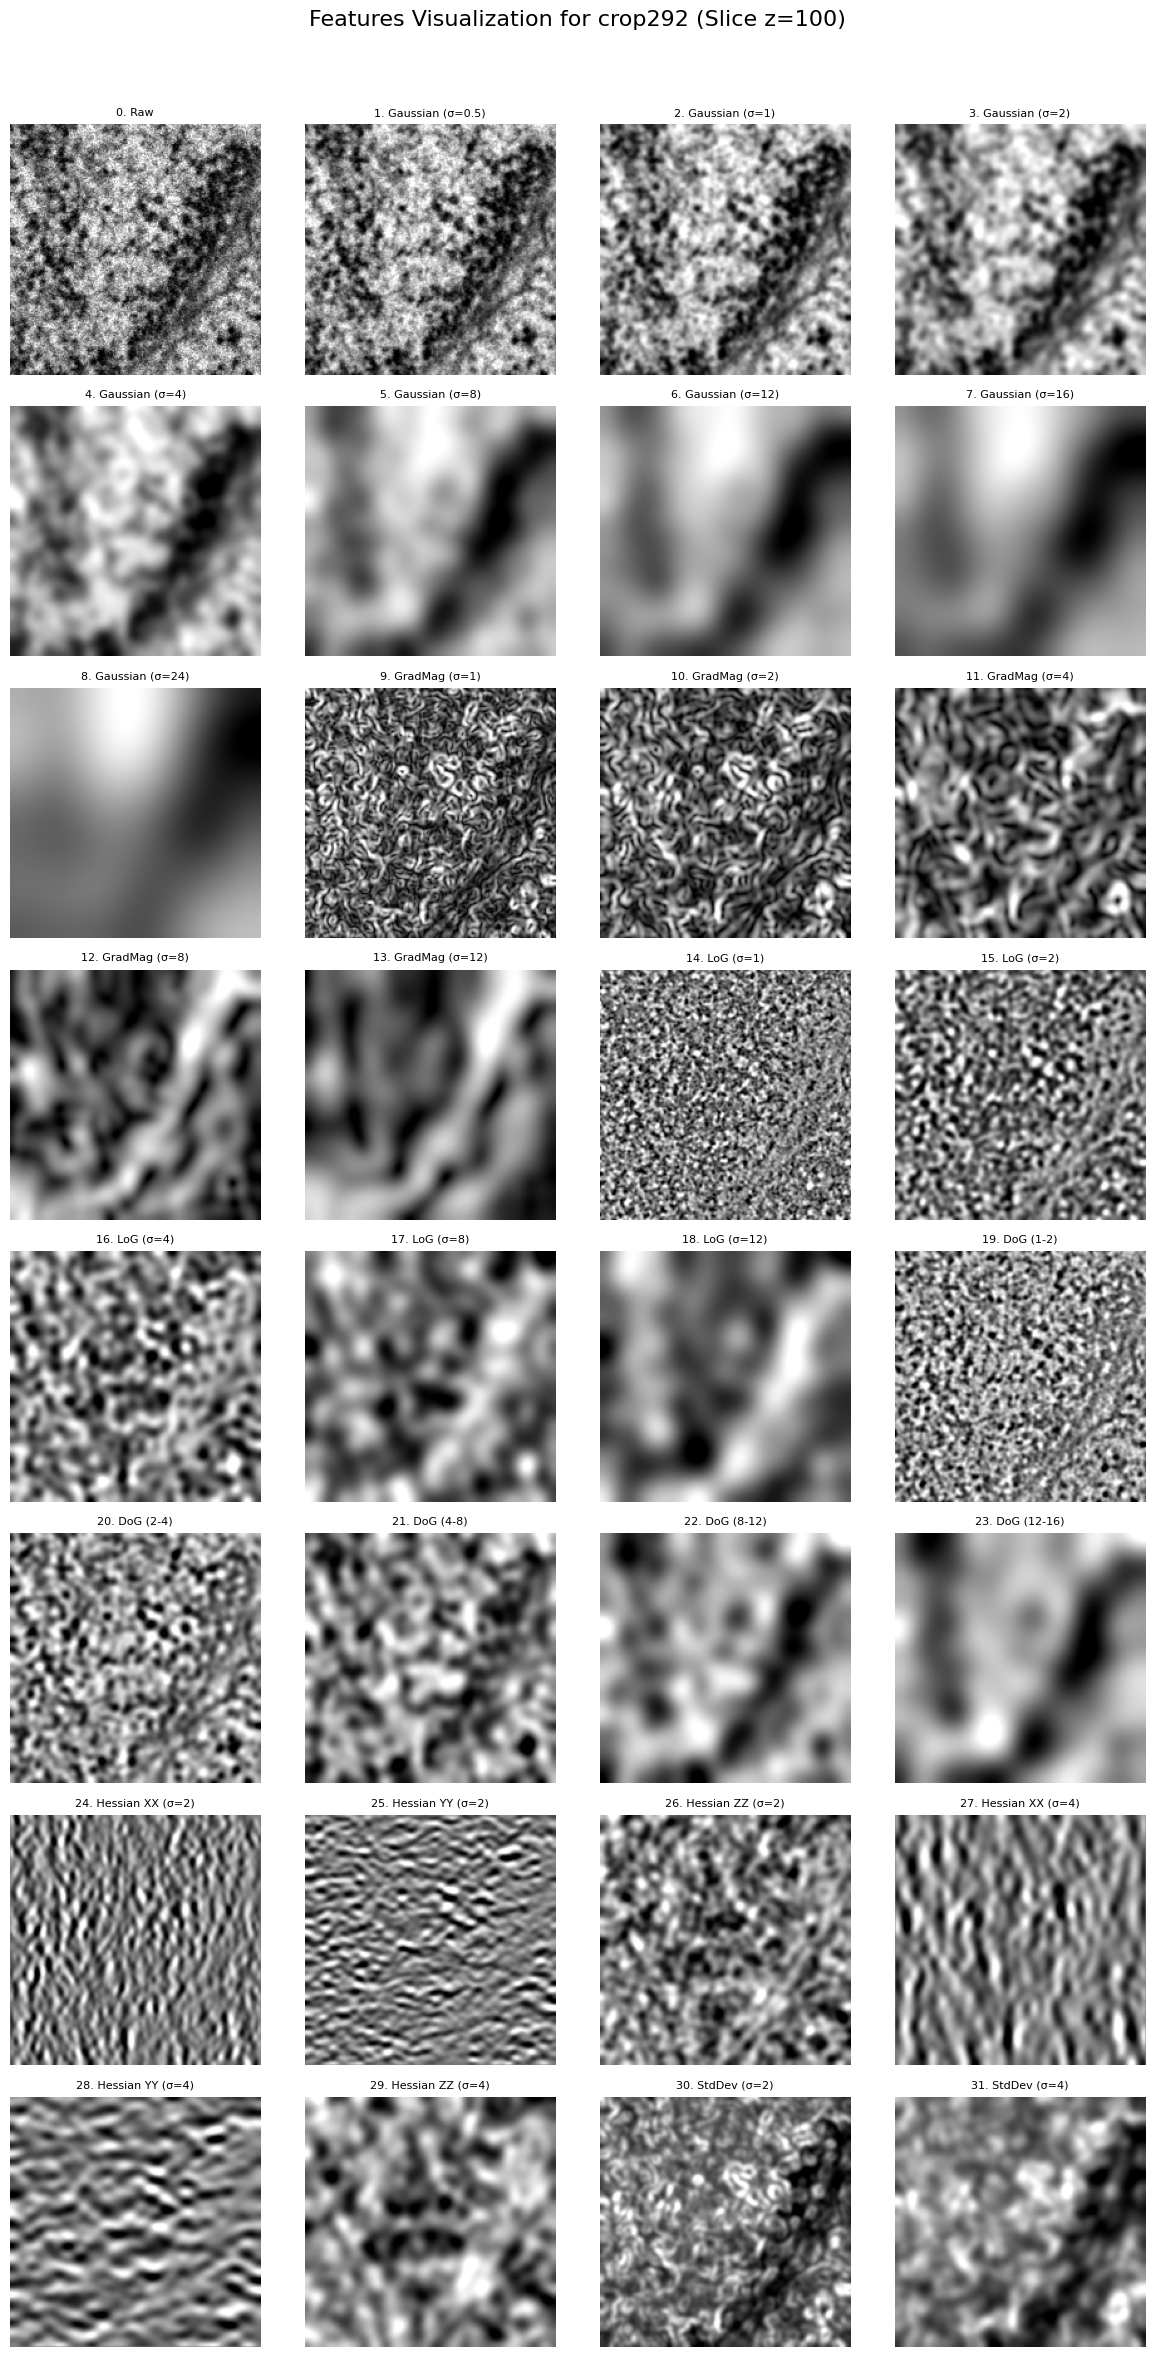

In [10]:
# ============================================================
# Step 2-4: Load multiple crops, align, and store (MODIFIED for s1)
# ============================================================

# List to store the loaded raw data, labels, and metadata for each crop
all_crops_data = []
crop_pixel_counts = []  # Stores total pixels (Dz * Dy * Dx) for each crop

# !!! 定义缩放因子：s1 是 s0 的 1/2 !!!
SCALE_FACTOR = 2

print("\n===== Loading and Aligning Multiple Crops (s1 Resolution) =====")

for crop_id in CROP_IDS:
    print(f"\nProcessing {crop_id}...")
    CROP_ROOT = os.path.join(GROUNDTRUTH_ROOT, crop_id)
    REF_S0 = os.path.join(CROP_ROOT, REF_CLASS, "s0")
    REF_ZATTR = os.path.join(CROP_ROOT, REF_CLASS, ".zattrs")

    # 1. Open reference zarr to get s0 shape (Ground Truth Shape)
    ref_zarr_s0 = zarr.open(REF_S0, mode="r")
    Dz_s0, Dy_s0, Dx_s0 = ref_zarr_s0.shape

    # --- Step 2. Read .zattrs (translation + scale based on s0) ---
    with open(REF_ZATTR, "r") as f:
        attrs = json.load(f)
    ms = attrs["multiscales"][0]["datasets"][0]
    scale = ms["coordinateTransformations"][0]["scale"]
    trans = ms["coordinateTransformations"][1]["translation"]
    scale_z, scale_y, scale_x = scale
    tz, ty, tx = trans

    # --- Step 3. Convert nm -> s0 voxel index -> s1 voxel index ---
    # a. Calculate s0 indices first
    vz0_s0 = int(tz / scale_z)
    vy0_s0 = int(ty / scale_y)
    vx0_s0 = int(tx / scale_x)

    # b. Convert to s1 indices (Divide by SCALE_FACTOR)
    vz0 = vz0_s0 // SCALE_FACTOR
    vy0 = vy0_s0 // SCALE_FACTOR
    vx0 = vx0_s0 // SCALE_FACTOR

    # c. Calculate s1 shape (Divide s0 shape by SCALE_FACTOR)
    Dz = Dz_s0 // SCALE_FACTOR
    Dy = Dy_s0 // SCALE_FACTOR
    Dx = Dx_s0 // SCALE_FACTOR

    # d. Calculate end indices for s1
    vz1, vy1, vx1 = vz0 + Dz, vy0 + Dy, vx0 + Dx

    # Load Raw Data (from s1 source, using s1 indices)
    # Assumes 'raw_zarr' variable points to the s1 zarr array
    raw_crop = raw_zarr[vz0:vz1, vy0:vy1, vx0:vx1]
    print(f"  Raw crop shape (s1): {raw_crop.shape}")

    # --- Step 4. Build multi-class label (s0 -> downsample -> s1) ---
    label_multi = np.zeros((Dz, Dy, Dx), dtype=np.uint8)

    for cname, real_id in SELECT_CLASSES.items():
        path = os.path.join(CROP_ROOT, cname, "s0")
        try:
            # Load s0 binary mask
            arr_s0 = zarr.open(path, mode="r")[:]

            # Downsample to s1: Slice every 2nd pixel [::2, ::2, ::2]
            arr_s1 = arr_s0[::SCALE_FACTOR, ::SCALE_FACTOR, ::SCALE_FACTOR]

            # Clip shape if mismatch (handle odd/even rounding issues)
            arr_s1 = arr_s1[:Dz, :Dy, :Dx]

            cid = CLASS_ID_MAP[cname]
            label_multi[arr_s1 > 0] = cid
        except Exception as e:
            print(f"  Warning: Failed to load class {cname} in {crop_id}. Error: {e}")

    # Safety Check: Ensure Raw and Label shapes match exactly
    if raw_crop.shape != label_multi.shape:
        print(
            f"  ! Shape Mismatch Fixed: Raw {raw_crop.shape} vs Label {label_multi.shape}"
        )
        min_z = min(raw_crop.shape[0], label_multi.shape[0])
        min_y = min(raw_crop.shape[1], label_multi.shape[1])
        min_x = min(raw_crop.shape[2], label_multi.shape[2])
        raw_crop = raw_crop[:min_z, :min_y, :min_x]
        label_multi = label_multi[:min_z, :min_y, :min_x]
        Dz, Dy, Dx = raw_crop.shape  # Update dimensions

    print(f"  Unique final multi-class labels in {crop_id}: {np.unique(label_multi)}")

    # Store the result and metadata
    all_crops_data.append(
        {"raw": raw_crop, "label": label_multi, "shape": (Dz, Dy, Dx), "id": crop_id}
    )
    crop_pixel_counts.append(Dz * Dy * Dx)

# ============================================================
# Step 5: Full 3D Feature Extraction and Merging (MODIFIED)
# ============================================================
print("\n===== Performing Feature Extraction and Merging =====")

X_all_crops_list = []
y_all_crops_list = []
n_feats = 0  # Initialize feature count

for crop_item in all_crops_data:
    raw_crop = crop_item["raw"]
    label_multi = crop_item["label"]

    print(f"  Extracting features for {crop_item['id']}...")

    # 1. Execute feature extraction on the current 3D volume
    X_vol_4d = extract_full_3d_features_32ch(raw_crop)

    # 💥 NEW: Store the 4D feature volume for fast visualization later (Step 9)
    crop_item["features_4d"] = X_vol_4d

    # Get feature count only once
    if n_feats == 0:
        n_feats = X_vol_4d.shape[-1]
        print(f"Total features per voxel: {n_feats}")

        # ============================================================
        # ✨ Feature Visualization Code (UPDATED FOR 32 CHANNELS)
        # ============================================================
        print("  --- Visualizing all 32 features for the first crop ---")

        Dz = raw_crop.shape[0]
        vis_z_feat = Dz // 2  # 取中间层看效果最好

        # 提取当前层的所有特征 (Y, X, 32)
        feat_slice = X_vol_4d[vis_z_feat, :, :, :]

        # 定义 32 个特征的名称 (必须与 extract_full_3d_features_32ch 的顺序一致)
        feature_names = [
            "0. Raw",
            "1. Gaussian (σ=0.5)",
            "2. Gaussian (σ=1)",
            "3. Gaussian (σ=2)",
            "4. Gaussian (σ=4)",
            "5. Gaussian (σ=8)",
            "6. Gaussian (σ=12)",
            "7. Gaussian (σ=16)",
            "8. Gaussian (σ=24)",
            "9. GradMag (σ=1)",
            "10. GradMag (σ=2)",
            "11. GradMag (σ=4)",
            "12. GradMag (σ=8)",
            "13. GradMag (σ=12)",
            "14. LoG (σ=1)",
            "15. LoG (σ=2)",
            "16. LoG (σ=4)",
            "17. LoG (σ=8)",
            "18. LoG (σ=12)",
            "19. DoG (1-2)",
            "20. DoG (2-4)",
            "21. DoG (4-8)",
            "22. DoG (8-12)",
            "23. DoG (12-16)",
            "24. Hessian XX (σ=2)",
            "25. Hessian YY (σ=2)",
            "26. Hessian ZZ (σ=2)",
            "27. Hessian XX (σ=4)",
            "28. Hessian YY (σ=4)",
            "29. Hessian ZZ (σ=4)",
            "30. StdDev (σ=2)",
            "31. StdDev (σ=4)",
        ]

        num_feats = feat_slice.shape[-1]  # 应该是 32

        # 动态计算行列数 (例如 4行8列)
        n_cols = 4
        n_rows = int(np.ceil(num_feats / n_cols))

        fig_feat, axes_feat = plt.subplots(
            n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows)  # 调整图片大小
        )
        fig_feat.suptitle(
            f"Features Visualization for {crop_item['id']} (Slice z={vis_z_feat})",
            fontsize=16,
        )

        axes_flat = axes_feat.flatten()

        for f_idx in range(num_feats):
            ax = axes_flat[f_idx]

            # 获取第 f_idx 个特征图
            feat_map = feat_slice[:, :, f_idx]

            # ===== 🔑 Robust Normalization (自动调整对比度) =====
            # 排除 NaN 和 Inf
            valid_pixels = feat_map[np.isfinite(feat_map)]
            if len(valid_pixels) > 0:
                vmin = np.percentile(valid_pixels, 1)
                vmax = np.percentile(valid_pixels, 99)
            else:
                vmin, vmax = 0, 1

            # 防止极端情况下 vmin == vmax
            if vmax <= vmin:
                if len(valid_pixels) > 0:
                    vmin, vmax = valid_pixels.min(), valid_pixels.max()
                else:
                    vmin, vmax = 0, 1

            im = ax.imshow(
                feat_map,
                cmap="gray",
                vmin=vmin,
                vmax=vmax,
                aspect="equal",
            )

            # 使用列表中的名字，如果越界则显示索引
            title_text = (
                feature_names[f_idx] if f_idx < len(feature_names) else f"Feat {f_idx}"
            )
            ax.set_title(title_text, fontsize=8)
            ax.axis("off")

        # 隐藏多余的空白子图
        for j in range(num_feats, len(axes_flat)):
            fig_feat.delaxes(axes_flat[j])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # ============================================================
    # ✨ End Feature Visualization Code
    # ============================================================

    # 2. Flatten the feature volume and label volume
    X_pixels = X_vol_4d.reshape(-1, n_feats)
    y_pixels = label_multi.reshape(-1)

    X_all_crops_list.append(X_pixels)
    y_all_crops_list.append(y_pixels)

# 3. Concatenate all flattened data into the final training/validation sets
# X_all_flat = np.concatenate(X_all_crops_list, axis=0)  # Total_Pixels x N_features
# y_all_flat = np.concatenate(y_all_crops_list, axis=0)  # Total_Pixels

# print(f"Total merged flat dataset size: {X_all_flat.shape[0]} pixels")

In [ ]:
# ============================================================
# NEW: Function Definition for Pixel Sampling
# ============================================================

def limit_class_pixels(X, y, max_per_class=50000, random_state=42):
    """
    Limit the number of pixels per class to avoid memory explosion and mitigate imbalance.
    """
    np.random.seed(random_state)
    X_list, y_list = [], []
    all_unique_classes = np.unique(y)

    print("\n===== Limiting class sizes =====")

    for c in all_unique_classes:
        idx = np.where(y == c)[0]
        count = len(idx)

        cname = "Background" if c == 0 else CLASS_NAMES_ORDERED[c - 1]
        print(f"Class {c} ({cname}): total {count} pixels")

        if count > max_per_class:
            selected = np.random.choice(idx, max_per_class, replace=False)
            print(f"   -> sampled {max_per_class}")
        else:
            selected = idx
            print(f"   -> kept all {count}")

        X_list.append(X[selected])
        y_list.append(y[selected])

    X_new = np.concatenate(X_list, axis=0)
    y_new = np.concatenate(y_list, axis=0)

    print(f"\nBalanced dataset size: {X_new.shape[0]} pixels")
    return X_new, y_new


# ============================================================
# Step 6: K-fold Cross Validation Setup (MODIFIED)
# ============================================================
# K-Fold split is based on the index of the crops
crop_indices = np.arange(len(CROP_IDS))
kf = KFold(n_splits=len(CROP_IDS), shuffle=True, random_state=42)

# Calculate cumulative pixel count indices to slice X_all_flat and y_all_flat
# This array tells us where each crop starts in the flattened dataset
crop_start_indices = np.cumsum([0] + crop_pixel_counts)

fold_scores = []

# ============================================================
# Step 7: Train & Validate (MODIFIED for Crop-based split & Chunking)
# ============================================================

for fold, (train_crop_idx, val_crop_idx) in tqdm(enumerate(kf.split(crop_indices)), total=kf.n_splits,
                                                 desc="K-Fold Progress"):
    print(f"\n================ FOLD {fold} ================")
    fold_start = time.time()

    # 1. Build Training Set (Concatenate all selected training crops)
    X_train_list, y_train_list = [], []
    for c_idx in train_crop_idx:
        start = crop_start_indices[c_idx]
        end = crop_start_indices[c_idx + 1]
        X_train_list.append(X_all_flat[start:end])
        y_train_list.append(y_all_flat[start:end])

    X_train_full = np.concatenate(X_train_list, axis=0)
    y_train_full = np.concatenate(y_train_list, axis=0)

    # 2. Build Validation Set (Single validation crop)
    val_c_idx = val_crop_idx[0]
    start = crop_start_indices[val_c_idx]
    end = crop_start_indices[val_c_idx + 1]

    X_val = X_all_flat[start:end]
    y_val = y_all_flat[start:end]
    print(f"FOLD {fold}: Validation Crop ID: {CROP_IDS[val_c_idx]}")

    # ------------------------------------------------------------
    # A. Apply pixel limit to the training set (Sampling)
    # ------------------------------------------------------------
    # 假设使用 50000 像素作为测试限制
    PIXEL_LIMIT = 50000
    print(f"FOLD {fold}: Applying pixel limit of {PIXEL_LIMIT} per class to training data...")
    X_train, y_train = limit_class_pixels(
        X_train_full,
        y_train_full,
        max_per_class=PIXEL_LIMIT,
        random_state=42 + fold
    )

    print(f"Fold {fold} Sampled Train set shape:", X_train.shape)
    print(f"Fold {fold} Val set shape:  ", X_val.shape)

    # ============================================================
    # Step C: Train RandomForest 🌳
    # ============================================================
    print("Training RandomForest...")
    clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=2, random_state=42)
    clf.fit(X_train, y_train)

    # ============================================================
    # Step D & E: Predict & Evaluate (USING CHUNKING)
    # ============================================================
    print("Predicting...")

    # --- NEW: Predict in Chunks to avoid OOM ---
    chunk_size = 8000000  # 800万像素点一个批次
    y_pred_list = []
    n_pixels = X_val.shape[0]
    n_chunks = int(np.ceil(n_pixels / chunk_size))

    for i in tqdm(range(n_chunks), desc="Predicting Chunks"):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, n_pixels)

        X_chunk = X_val[start_idx:end_idx]

        # 使用训练好的模型对小块进行预测
        y_pred_chunk = clf.predict(X_chunk)
        y_pred_list.append(y_pred_chunk)

    # 将所有小块的预测结果拼接回完整的预测结果
    y_pred = np.concatenate(y_pred_list, axis=0)
    print(f"Prediction complete. Final shape: {y_pred.shape}")
    # ------------------------------------------------------------

    # Calculate scores PER CLASS for the 5 target classes
    iou_per_class = jaccard_score(y_val, y_pred, average=None, labels=labels_eval, zero_division=0)
    dice_per_class = f1_score(y_val, y_pred, average=None, labels=labels_eval, zero_division=0)

    iou_macro = np.mean(iou_per_class)
    dice_macro = np.mean(dice_per_class)

    print(f"FOLD {fold} Result: IoU_macro={iou_macro:.4f}, Dice_macro={dice_macro:.4f}")

    # Store results
    fold_scores.append({
        'iou_macro': iou_macro,
        'dice_macro': dice_macro,
        'iou_per_class': iou_per_class,
        'dice_per_class': dice_per_class
    })

    elapsed = time.time() - fold_start
    print(f"⏱ Fold {fold} took {elapsed / 60:.2f} minutes")


# ============================================================
# Step 7.5: Train final model on ALL data (Balanced Sampling) (MINOR MODIFICATION)
# ============================================================

print("\n===== Step 7.5: Training final model on ALL data (Balanced Sampling) =====")

# Apply the sampling to the full dataset (X_all_flat, y_all_flat)
X_sub, y_sub = limit_class_pixels(X_all_flat, y_all_flat, max_per_class=50000)

print("Training FINAL RandomForest model...")

final_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=2,  # Use all cores
    random_state=42,
)

final_clf.fit(X_sub, y_sub)

print("🎉 Final model training complete!")

# ============================================================
# Step 8: Print final aggregated results (NO CHANGE)
# ============================================================
print("\n================ Final K-fold Results ================\n")

# Aggregate per-class scores across all folds
all_iou_per_class = np.array([s['iou_per_class'] for s in fold_scores])
all_dice_per_class = np.array([s['dice_per_class'] for s in fold_scores])

# Calculate average per-class scores
avg_iou_per_class = np.mean(all_iou_per_class, axis=0)
avg_dice_per_class = np.mean(all_dice_per_class, axis=0)

# Print detailed results per fold
for k, scores in enumerate(fold_scores):
    print(f"Fold {k}:   IoU_macro={scores['iou_macro']:.4f}   Dice_macro={scores['dice_macro']:.4f}")

print("\n---------------- Detailed Class Averages ----------------")
print("Class | Avg IoU (Jaccard) | Avg Dice (F1)")
print("------|-------------------|---------------")
for i, cname in enumerate(CLASS_NAMES_ORDERED):
    print(f"{cname:6s}| {avg_iou_per_class[i]:.4f} | {avg_dice_per_class[i]:.4f}")

    # Calculate final macro averages
avg_macro_iou = np.mean(avg_iou_per_class)
avg_macro_dice = np.mean(avg_dice_per_class)

print("\n================ Aggregated Macro Scores ================")
print(f"Average Macro IoU (5 classes): {avg_macro_iou:.4f}")
print(f"Average Macro Dice (5 classes): {avg_macro_dice:.4f}")

# ============================================================
# Step 9: Save 10 random prediction slices per crop (MODIFIED)
# ============================================================

# ---- 1. Determine the next experiment number (i) ----
result_root = "../Result"
os.makedirs(result_root, exist_ok=True)
existing_dirs = [d for d in os.listdir(result_root) if d.startswith("predict")]
max_i = 0
for d in existing_dirs:
    try:
        # Extract the number 'i' from 'predict(i)'
        # Handles both 'predict(1)' and 'predict1' formats, focusing on extracting the number
        num_str = ''.join(filter(str.isdigit, d))
        if num_str:
            max_i = max(max_i, int(num_str))
    except:
        continue  # Ignore non-standard directories

next_i = max_i + 1
experiment_folder = os.path.join(result_root, f"predict({next_i})")
os.makedirs(experiment_folder, exist_ok=True)

print(f"\nSaving visualizations into new experiment folder: {experiment_folder}")

# ---- 2. Iterate through all crops and save 10 random slices each ----
num_vis_per_crop = 10

# Convert all_crops_data list into a dictionary for easy access by crop_id
crops_data_dict = {item['id']: item for item in all_crops_data}

# Use the final_clf trained on all balanced data
if 'final_clf' not in locals():
    print("Warning: final_clf not found. Skipping visualization.")
else:
    for crop_id in CROP_IDS:
        crop_item = crops_data_dict[crop_id]

        # Create the subfolder for the current crop: predict(i)/crop_id
        crop_save_folder = os.path.join(experiment_folder, crop_id)
        os.makedirs(crop_save_folder, exist_ok=True)

        print(f"\n--- Processing {crop_id} (Saving {num_vis_per_crop} slices) ---")

        raw_crop_vis = crop_item['raw']
        label_multi_vis = crop_item['label']
        Dz, Dy, Dx = crop_item['shape']

        # Retrieve the pre-computed 4D feature volume
        # We rely on 'features_4d' being added in Step 5
        feat_vol_4d = crop_item['features_4d']

        # Select 10 unique random Z slices
        if Dz < num_vis_per_crop:
            vis_zs = range(Dz)  # Use all slices if less than 10
            print(f"Crop Z size ({Dz}) is less than 10, visualizing all slices.")
        else:
            vis_zs = random.sample(range(Dz), num_vis_per_crop)

        for i, vis_z in enumerate(vis_zs):
            # 3. Predict on the slice
            feat_vis_slice = feat_vol_4d[vis_z, :, :, :]
            X_vis = feat_vis_slice.reshape(-1, n_feats)
            y_pred_vis = final_clf.predict(X_vis).reshape(Dy, Dx)

            # GT & raw (retrieve original data)
            y_gt_vis = label_multi_vis[vis_z]
            raw_vis = raw_crop_vis[vis_z]

            # ---- Visualization ----
            fig = plt.figure(figsize=(18, 6))

            plt.suptitle(f"Exp: {next_i} | Crop: {crop_id}, Slice z={vis_z}", fontsize=16)

            # --- Raw ---
            plt.subplot(1, 3, 1)
            plt.title("Raw")
            plt.imshow(raw_vis, cmap='gray')
            plt.axis("off")

            # --- Ground Truth ---
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            # Ensure the color map handles the range 0-5
            plt.imshow(y_gt_vis, cmap="tab10", vmin=0, vmax=9)
            plt.axis("off")

            # --- Prediction ---
            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(y_pred_vis, cmap="tab10", vmin=0, vmax=9)
            plt.axis("off")

            plt.tight_layout(rect=[0, 0, 1, 0.94])

            # Save image
            # Filename: slice_001_z123.png
            save_path = os.path.join(crop_save_folder, f"slice_{i + 1:02d}_z{vis_z:04d}.png")
            plt.savefig(save_path, dpi=200)
            plt.close()

            print(f"  [{i + 1}/{len(vis_zs)}] Saved: {save_path}")

    print("\n--- Script Finished ---")